<a href="https://colab.research.google.com/github/AriSu2904/gist/blob/main/rf_model_screening_kandidat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Change raw data to CSV

In [202]:
import pandas as pd

df = pd.read_json("/content/combined-candidate.json")

df.to_csv("enigma_dataset_2022_2024_v1.csv", index=False)

# Data Exploration

In [203]:
import pandas as pd

print(df.shape)
print(df.info())
print(df.head())

(1175, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1175 entries, 0 to 1174
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   first_name    1175 non-null   object 
 1   last_name     1175 non-null   object 
 2   nik           1175 non-null   int64  
 3   nick_name     1175 non-null   object 
 4   email         1175 non-null   object 
 5   phone         1175 non-null   object 
 6   dob           1175 non-null   object 
 7   address       1175 non-null   object 
 8   batch         1175 non-null   int64  
 9   skills        1175 non-null   object 
 10  total_skills  1175 non-null   int64  
 11  experience    1175 non-null   int64  
 12  basic_test    1175 non-null   float64
 13  math_test     1175 non-null   int64  
 14  coding_test   1175 non-null   int64  
dtypes: float64(1), int64(6), object(8)
memory usage: 137.8+ KB
None
  first_name    last_name               nik nick_name  \
0    Hermann    Lueilwitz

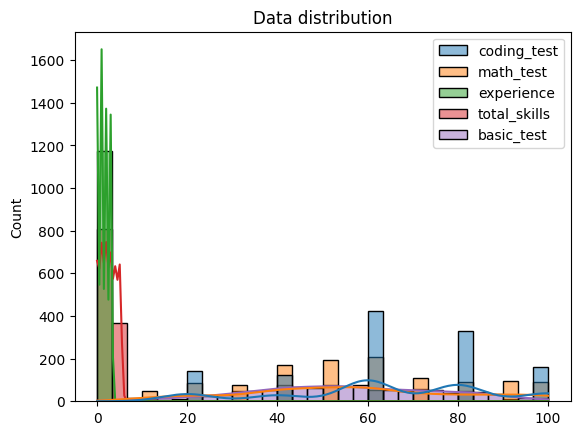

In [204]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df[['coding_test', 'math_test', 'experience', 'total_skills', 'basic_test']], bins=30, kde=True)
plt.title('Data distribution')
plt.show()

# Feature engineering

status
Lulus              408
Dipertimbangkan    399
Tidak Lulus        368
Name: count, dtype: int64
status
Lulus              0.347234
Dipertimbangkan    0.339574
Tidak Lulus        0.313191
Name: proportion, dtype: float64


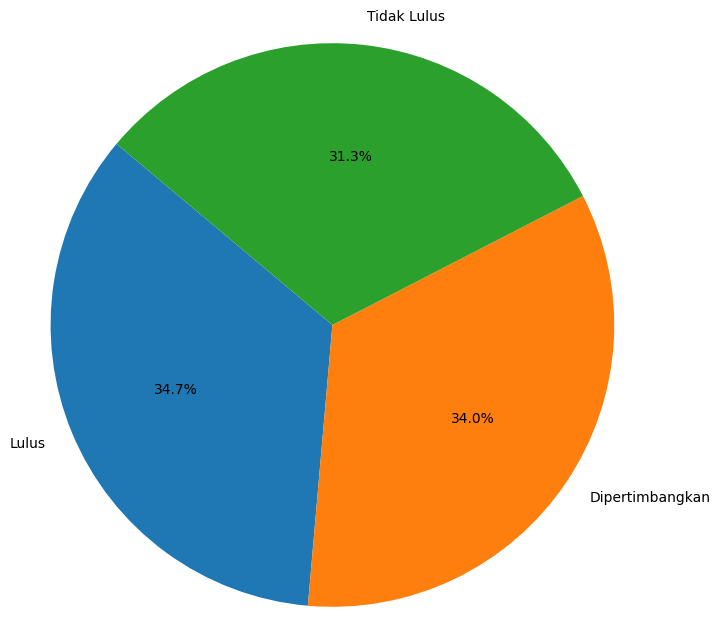

In [205]:
# Calculate scores
df['sk_exp'] = 1 * df['total_skills'] * df['experience'] + 10
df['basic_score'] = (df['basic_test'] * 0.15) + (df['math_test'] * 0.15)
df['coding_score'] = df['coding_test'] * 0.6

# Compute total as temporary variable
total = df['sk_exp'] + df['basic_score'] + df['coding_score']

# Define a function with if-else logic
def assign_status(score):
    if score >= 75:
        return 'Lulus'
    elif 65 <= score < 75:
        return 'Dipertimbangkan'
    else:
        return 'Tidak Lulus'

# Apply the function element-wise
df['status'] = total.apply(assign_status)

def status_to_numeric(status):
    if status == 'Lulus':
        return 2
    elif status == 'Dipertimbangkan':
        return 1
    else:
        return 0

# Terapkan ke kolom baru
df['numeric_status'] = df['status'].apply(status_to_numeric)

# Show results
print(df['status'].value_counts())

status_counts = df['status'].value_counts(normalize=True)
print(status_counts)

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.show()


In [206]:
print(df['status'].value_counts())
status_counts = df['status'].value_counts(normalize=True)
print(status_counts)

status
Lulus              408
Dipertimbangkan    399
Tidak Lulus        368
Name: count, dtype: int64
status
Lulus              0.347234
Dipertimbangkan    0.339574
Tidak Lulus        0.313191
Name: proportion, dtype: float64


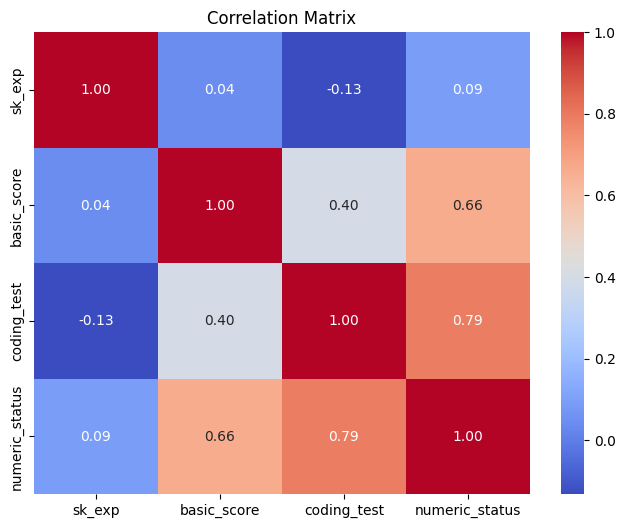

In [207]:
import seaborn as sns
import matplotlib.pyplot as plt

# Korelasi antar fitur numerik
correlation = df[['sk_exp', 'basic_score', 'coding_test', 'numeric_status']].corr()

# Visualisasi
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


# Training preparation

In [213]:
from sklearn.model_selection import train_test_split

X = df[['sk_exp', 'basic_score', 'coding_score']]
y = df['numeric_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print(f"Jumlah data training   : {len(X_train)}")
print(f"Jumlah data testing    : {len(X_test)}")

Jumlah data training   : 940
Jumlah data testing    : 235


# Training

Jumlah data yang salah klasifikasi: 1
     actual_status  predicted_status
106              1                 0


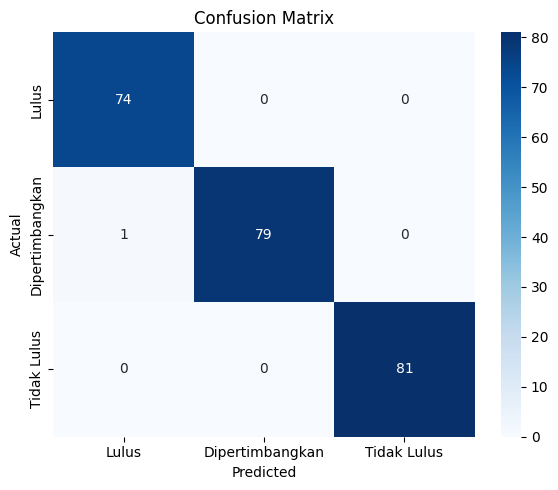

                 precision    recall  f1-score     support
Lulus             0.986667  1.000000  0.993289   74.000000
Dipertimbangkan   1.000000  0.987500  0.993711   80.000000
Tidak Lulus       1.000000  1.000000  1.000000   81.000000
accuracy          0.995745  0.995745  0.995745    0.995745
macro avg         0.995556  0.995833  0.995666  235.000000
weighted avg      0.995801  0.995745  0.995746  235.000000
Akurasi: 99.57%


In [214]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_test_df = pd.DataFrame(y_test).reset_index(drop=True)
y_pred_df = pd.DataFrame(y_pred, columns=["predicted_status"])

result_df = X_test.copy().reset_index(drop=True)
result_df["actual_status"] = y_test_df
result_df["predicted_status"] = y_pred_df

misclassified = result_df[result_df["actual_status"] != result_df["predicted_status"]]

print("Jumlah data yang salah klasifikasi:", len(misclassified))
print(misclassified[["actual_status", "predicted_status"]])


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Lulus", "Dipertimbangkan", "Tidak Lulus"], yticklabels=["Lulus", "Dipertimbangkan", "Tidak Lulus"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

report = classification_report(y_test, y_pred, target_names=["Lulus", "Dipertimbangkan", "Tidak Lulus"], output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df[['precision', 'recall', 'f1-score', 'support']])
print(f"Akurasi: {accuracy_score(y_test, y_pred) * 100:.2f}%")

# Save model

In [215]:
import joblib

joblib.dump(model, 'enigma_model_rf_v1.sav')

['enigma_model_rf_v1.sav']

# Feature importance

<ipython-input-216-033d10e562e0>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")


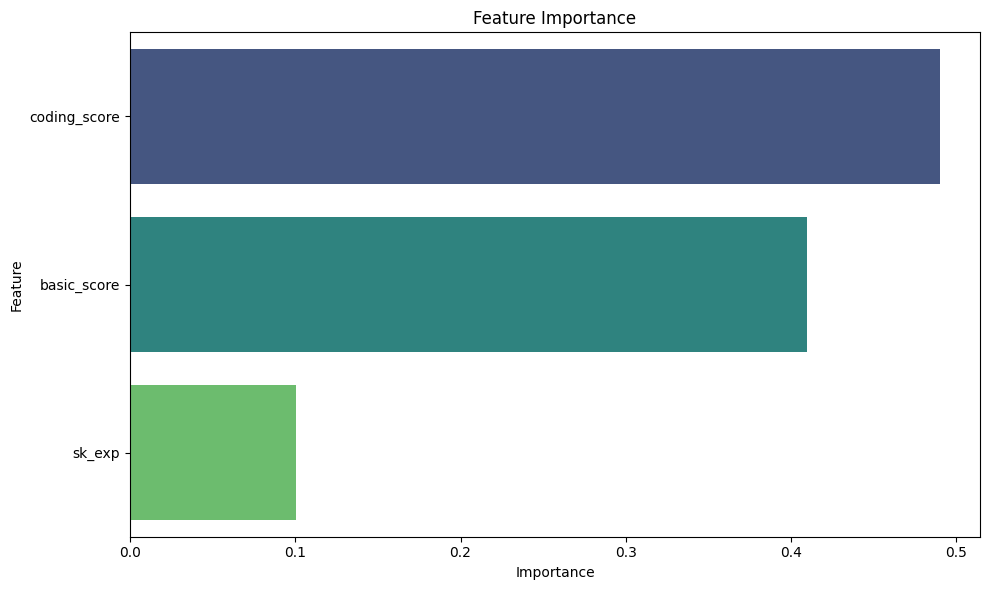

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = model.feature_importances_
features = X.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

# Cross validation

In [217]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = RandomForestClassifier(random_state=42)

scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')

print("Cross-validation scores:", scores)
print("Mean CV accuracy: {:.4f}".format(scores.mean()))


Cross-validation scores: [0.97021277 0.96595745 0.99574468 0.99148936 0.99574468]
Mean CV accuracy: 0.9838
